In [25]:
from keras.models import Model
from nbeats_keras.model import NBeatsNet
from keras.layers import Input, Dense, Subtract, Add
from keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
# Define the N-BEATS block
def nbeats_block(input_shape, theta_dim):
    input_layer = Input(shape=input_shape)
    x = Dense(128, activation='relu')(input_layer)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    theta_layer = Dense(theta_dim, activation='linear')(x)
    output_layer = Subtract()([input_layer, theta_layer])
    return Model(inputs=input_layer, outputs=[output_layer, theta_layer])

In [27]:
def nbeats_model(input_shape, output_shape, num_blocks):
    input_layer = Input(shape=input_shape)
    x = input_layer
    theta_layers = []  # List to collect all theta layers
    for _ in range(num_blocks):
        x, theta = nbeats_block(input_shape, output_shape)(x)
        theta_layers.append(theta)
    output_layer = Add()(theta_layers)  # Pass the list of theta layers to the Add() layer
    return Model(inputs=input_layer, outputs=output_layer)

In [28]:
# Load the dataset
data = pd.read_csv('merged_data.csv', parse_dates=['DateTime'], index_col='DateTime')

In [29]:
# # Normalize the data
# scaler = MinMaxScaler(feature_range=(0, 1))
# data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

# # Create a separate scaler for the target variable
# target_scaler = MinMaxScaler(feature_range=(0, 1))
# data['MeanEnergyConsumption'] = target_scaler.fit_transform(data[['MeanEnergyConsumption']])

In [30]:
# Choose a number of time steps
n_steps_in, n_steps_out = 10, 1

In [31]:
# Split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # Find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # Check if we are beyond the dataset
        if out_end_ix >= len(sequences):
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequences.iloc[i:end_ix, :], sequences.iloc[end_ix:out_end_ix+1, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [32]:
# Determine the number of data points in a week
points_per_week = 2*24*7  # For data recorded every 30 minutes
points_per_week = points_per_week*2  # For data recorded every 15 minutes

In [33]:
# Split the dataset into training set and test set
train, test = data[:-points_per_week], data[-points_per_week:]

In [34]:
# # Split the dataset into training set and test set
# train_size = int(len(data) * 0.8)
# train, test = data[:train_size], data[train_size:]

In [35]:
# Prepare the training set
X_train, y_train = split_sequences(train, n_steps_in, n_steps_out)

In [36]:
# # Reshape from [samples, timesteps] into [samples, timesteps, features]
# n_features = X.shape[2]
# X = X.reshape((X.shape[0], X.shape[1], n_features))

In [37]:
# # Define the input and output shapes
# input_shape = (n_steps_in, data.shape[1])  # 10 previous time steps and 9 features
# output_shape = n_steps_out  # Predict the next time step
# num_blocks = 3  # Use 3 N-BEATS blocks

In [38]:
# Define the hyperparameters
stack_types = ('trend', 'seasonality')
num_stacks = 30
num_layers = 4
num_hidden_units = 512
learning_rate = 0.001
batch_size = 32

In [39]:
# # Create the model
# model = nbeats_model(input_shape, output_shape, num_blocks)

# Create the model
model = NBeatsNet(backcast_length=10, forecast_length=5,
                  stack_types=stack_types, nb_blocks_per_stack=num_stacks,
                  thetas_dim=(4, 8), share_weights_in_stack=True,
                  hidden_layer_units=num_hidden_units)

In [40]:
# Compile the model
model.compile(loss='mae', optimizer=Adam(learning_rate))

In [41]:
# Train the model on the training set
model.fit(X_train, y_train, batch_size=batch_size, epochs=10, verbose=0)

In [42]:
# # Online learning
# for i in range(len(train) - n_steps_in - n_steps_out + 1):
#     x = train.iloc[i:i+n_steps_in, :]  # Get the last n_steps_in time steps
#     y = train.iloc[i+n_steps_in:i+n_steps_in+n_steps_out, 0]  # Get the next n_steps_out time step
#     x = np.expand_dims(x, axis=0)  # Add an extra dimension to x
#     y = np.expand_dims(y, axis=0)  # Add an extra dimension to y
#     model.fit(x, y, epochs=1, verbose=0)  # Train the model

In [57]:
# Prepare the test set
X_test, y_test = split_sequences(test, n_steps_in, n_steps_out)
print(X_test.shape, y_test.size, y_test.shape)
print(X_test[0], y_test[0])

(662, 10, 9) 662 (662, 1)
[[  0.2188598    2.6          0.           7.05         0.
    2.5         18.5          0.           0.        ]
 [  0.18954253   2.45         0.          11.1          0.
    0.          37.           0.           0.        ]
 [  0.17079472   2.275        0.          14.85         0.
    0.          49.5          0.           0.        ]
 [  0.15332754   2.1          0.          18.6          0.
    0.          62.           0.           0.        ]
 [  0.14710038   1.9          0.          22.65         0.
    0.          75.5          0.           0.        ]
 [  0.13890063   1.7          0.          26.7          0.
    0.          89.           0.           0.        ]
 [  0.1338473    1.575        0.          30.0000015    0.5
    2.          94.5          0.           0.        ]
 [  0.12961509   1.45         0.          33.300003     1.
    4.         100.           0.           0.        ]
 [  0.1301366    1.425        0.          51.000004     2.
  

In [44]:
# Assuming 'model' is your trained model and 'X_test' is your test data
# And '336' is the number of 30-minute intervals in a week

predictions = model.predict(X_test[:672])

21/21 [==============================] - 4s 39ms/step


In [45]:
# # Generate predictions for the test set
# predictions = []
# test_timestamps = []
# for i in range(len(test) - n_steps_in - n_steps_out + 1):
#     x = test.iloc[i:i+n_steps_in, :]  # Get the last n_steps_in time steps
#     y = test.iloc[i+n_steps_in:i+n_steps_in+n_steps_out, 0]  # Get the next n_steps_out time step
#     x = np.expand_dims(x, axis=0)  # Add an extra dimension to x
#     y = np.expand_dims(y, axis=0)  # Add an extra dimension to y
#     pred = model.predict(x)
#     predictions.append(pred[0, 0])
#     test_timestamps.append(test.index[i + n_steps_in])

In [46]:
# # Inverse transform the predictions and the actual values
# y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
# predictions_inv = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

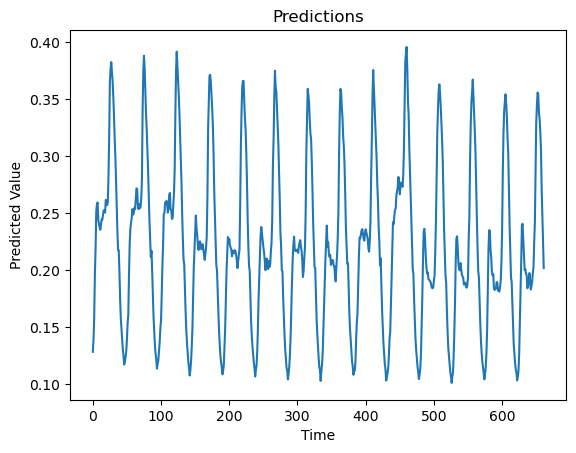

662
662


In [47]:
# Average the predictions over the second dimension
predictions_avg = np.mean(predictions, axis=1)
# Assuming 'predictions' is your array of predictions
plt.plot(predictions_avg)
plt.title('Predictions')
plt.xlabel('Time')
plt.ylabel('Predicted Value')
plt.show()
print(predictions_avg.size)
print(y_test.size)

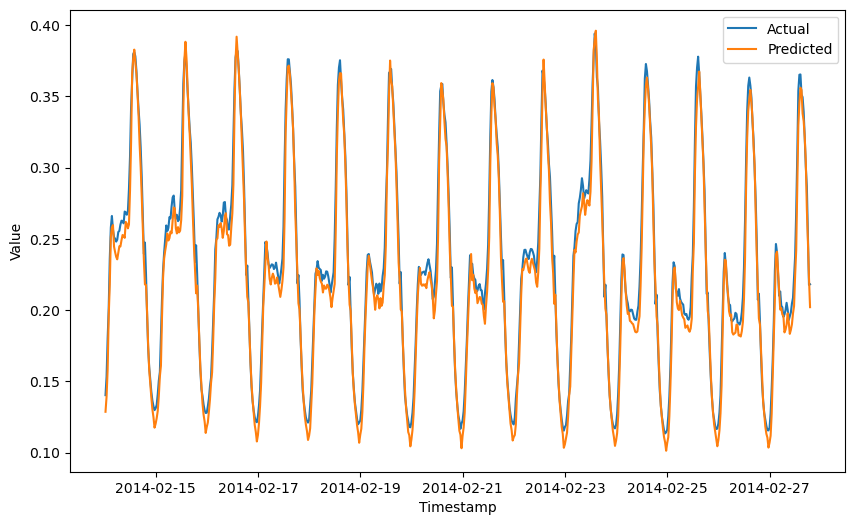

In [48]:
# Plot the actual values against the predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index[:len(y_test)], y_test, label='Actual')
plt.plot(test.index[:len(predictions_avg)], predictions_avg, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()